In [1]:
# Cell 1: 导入库
"""
BERT微调需要的库
- transformers: HuggingFace库，提供BERT模型和Trainer
- torch: PyTorch深度学习框架
"""

import sys
sys.path.append('..')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer  # HuggingFace的训练工具
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

# 导入自定义Dataset
from src.utils.bert_dataset import BertDataset

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 检查GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
print(" 导入成功")

使用设备: cuda
 导入成功


In [2]:
# Cell 2: 加载BERT tokenizer和数据
"""
加载bert-base-chinese的tokenizer
使用BertDataset处理训练数据
"""

print("加载tokenizer和数据...")

# 加载tokenizer
model_name = 'bert-base-chinese'
tokenizer = BertTokenizer.from_pretrained(model_name)

print(f" Tokenizer加载完成")
print(f"词表大小: {tokenizer.vocab_size:,}")

# 创建数据集（使用BertDataset）
max_len = 128  # BERT最大长度

train_dataset = BertDataset(
    '../data/processed/train.csv',
    tokenizer,
    max_len=max_len
)

val_dataset = BertDataset(
    '../data/processed/val.csv',
    tokenizer,
    max_len=max_len
)

test_dataset = BertDataset(
    '../data/processed/test.csv',
    tokenizer,
    max_len=max_len
)

print(f"\n训练集: {len(train_dataset)} 条")
print(f"验证集: {len(val_dataset)} 条")
print(f"测试集: {len(test_dataset)} 条")

# 创建DataLoader
batch_size = 32  # BERT显存占用大，batch_size要小一些

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nBatch size: {batch_size}")
print(f"训练batches: {len(train_loader)}")
print(f"验证batches: {len(val_loader)}")

print("\n 数据加载完成")

加载tokenizer和数据...
 Tokenizer加载完成
词表大小: 21,128
 加载数据: 45462 条
Max length: 128
 加载数据: 9742 条
Max length: 128
 加载数据: 9743 条
Max length: 128

训练集: 45462 条
验证集: 9742 条
测试集: 9743 条

Batch size: 32
训练batches: 1421
验证batches: 305

 数据加载完成


In [3]:
# Cell 3: 初始化BERT分类模型
"""
BertForSequenceClassification = BERT + 分类头
- BERT部分：预训练好的（110M参数）
- 分类头：随机初始化（需要训练）
"""

print("初始化BERT模型...")

model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=14  # 二分类任务
)
model.to(device)
# 打印模型信息
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f" BERT模型初始化完成")
print(f"\n模型参数:")
print(f"  总参数量: {total_params/1e6:.1f}M")
print(f"  可训练参数: {trainable_params/1e6:.1f}M")
print(f"  说明: 所有参数都会微调（BERT层 + 分类层）")

print(f"\n模型结构:")
print(f"  BERT encoder: 12层Transformer")
print(f"  Hidden size: 768")
print(f"  分类头: Linear(768 → 14)")

初始化BERT模型...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 BERT模型初始化完成

模型参数:
  总参数量: 102.3M
  可训练参数: 102.3M
  说明: 所有参数都会微调（BERT层 + 分类层）

模型结构:
  BERT encoder: 12层Transformer
  Hidden size: 768
  分类头: Linear(768 → 14)


In [ ]:
# Cell 4: 训练和评估函数（混合精度优化）
"""
使用FP16混合精度训练，速度提升30-50%
准确率几乎不受影响
"""

from torch.cuda.amp import autocast, GradScaler

def train_epoch(model, dataloader, optimizer, scheduler, device, scaler):
    """训练一个epoch（混合精度版本）"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(dataloader, desc='Training'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        # 混合精度前向传播
        with autocast():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits.float()  # 转FP32计算准确率
        
        # 混合精度反向传播
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        if scheduler is not None:
            scheduler.step()
        
        # 统计
        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

def evaluate(model, dataloader, device):
    """评估模型"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            input_ids=batch['input_ids'].to(device)
            attention_mask=batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels ).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

print(" 训练函数定义完成")

 训练函数定义完成


In [ ]:
# Cell 5: 训练配置（优化版）
"""
BERT微调配置 + 混合精度
"""

# 优化器
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.cuda.amp import GradScaler

optimizer = AdamW(
    model.parameters(),
    lr=2e-5,
    eps=1e-8,
    weight_decay=0.01
)

# 混合精度scaler
scaler = GradScaler()
print("混合精度已启用")

# 训练轮数
num_epochs = 5  # 5 → 3（BERT微调3个epochs足够）

# 学习率调度器
num_warmup_steps = len(train_loader)
num_training_steps = num_epochs * len(train_loader)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)
# 损失函数（其实用不到，因为model会自动算loss）
criterion = nn.CrossEntropyLoss()

# 记录训练历史
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0

print(" 训练配置完成")
print(f"\n配置详情:")
print(f"  优化器: AdamW")
print(f"  学习率: 2e-5（BERT标准）")
print(f"  Epochs: {num_epochs}")
print(f"  Batch size: {batch_size}")
print(f"  学习率调度: Linear with warmup")
print(f"  总训练步数: {num_training_steps:,}")

混合精度已启用
 训练配置完成

配置详情:
  优化器: AdamW
  学习率: 2e-5（BERT标准）
  Epochs: 3
  Batch size: 32
  学习率调度: Linear with warmup
  总训练步数: 4,263


C:\Users\ysn\AppData\Local\Temp\ipykernel_36976\404576891.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [6]:
# Cell 6: 开始训练BERT！
"""
BERT微调训练
注意：BERT训练比TextCNN慢（模型大）
预计每个epoch需要30-60分钟（CPU）或5-10分钟（GPU）
"""

print("="*60)
print("开始BERT微调训练")
print("="*60)
print(f"设备: {device}")
print(f"预计时间: {'5-10分钟/epoch (GPU)' if device.type == 'cuda' else '30-60分钟/epoch (CPU)'}")
print("="*60)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 40)
    
    # 训练（传入scheduler和scaler）
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, scheduler, device, scaler
    )
    
    # 验证
    val_loss, val_acc = evaluate(model, val_loader, device)
    
    # 打印结果
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '../output/bert_best.pth')
        print(f"保存最佳模型 (Val Acc: {val_acc:.2f}%)")
print("\n" + "="*60)
print(" BERT训练完成！")
print("="*60)
print(f"最佳验证准确率: {best_val_acc:.2f}%")

开始BERT微调训练
设备: cuda
预计时间: 5-10分钟/epoch (GPU)

Epoch 1/3
----------------------------------------


Training:   0%|          | 0/1421 [00:00<?, ?it/s]C:\Users\ysn\AppData\Local\Temp\ipykernel_36976\681389910.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Evaluating: 100%|██████████| 305/305 [02:01<00:00,  2.50it/s]


Train Loss: 0.6635, Train Acc: 83.41%
Val Loss: 0.1806, Val Acc: 95.33%
保存最佳模型 (Val Acc: 95.33%)

Epoch 2/3
----------------------------------------


Evaluating: 100%|██████████| 305/305 [02:10<00:00,  2.34it/s]


Train Loss: 0.1240, Train Acc: 96.68%
Val Loss: 0.1400, Val Acc: 96.24%
保存最佳模型 (Val Acc: 96.24%)

Epoch 3/3
----------------------------------------


Evaluating: 100%|██████████| 305/305 [02:13<00:00,  2.28it/s]


Train Loss: 0.0558, Train Acc: 98.50%
Val Loss: 0.1400, Val Acc: 96.58%
保存最佳模型 (Val Acc: 96.58%)

 BERT训练完成！
最佳验证准确率: 96.58%


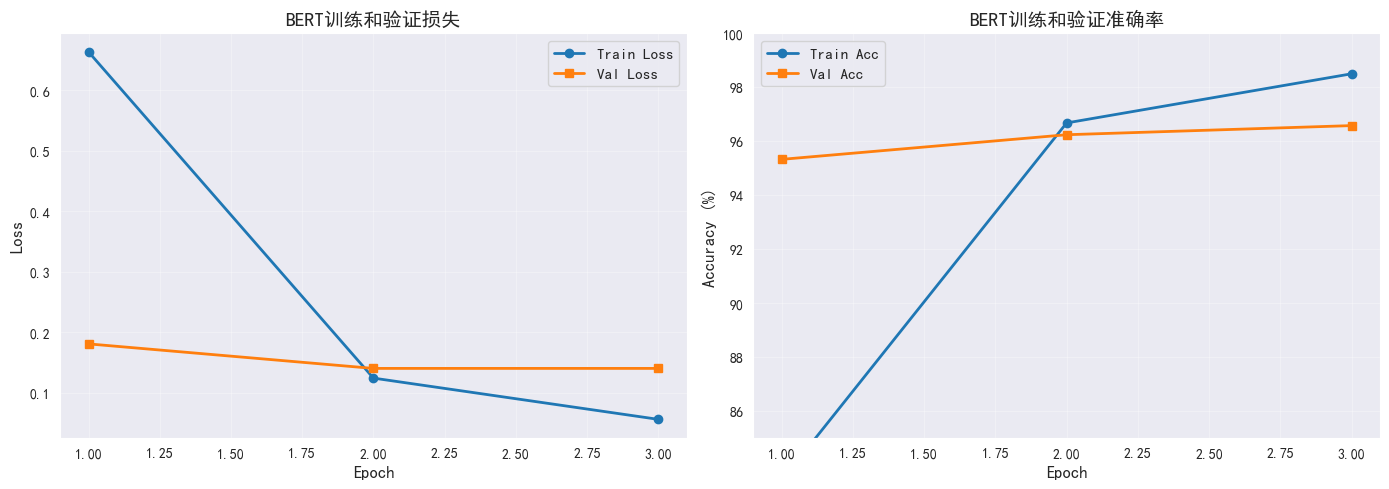

训练曲线已保存到 output/bert_training_curve.png


In [7]:
# Cell 7: 可视化BERT训练过程
"""
绘制BERT的训练曲线
对比训练集和验证集的表现
"""

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, num_epochs + 1)

# 损失曲线
ax1.plot(epochs_range, history['train_loss'], label='Train Loss', marker='o', linewidth=2)
ax1.plot(epochs_range, history['val_loss'], label='Val Loss', marker='s', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('BERT训练和验证损失', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 准确率曲线
ax2.plot(epochs_range, history['train_acc'], label='Train Acc', marker='o', linewidth=2)
ax2.plot(epochs_range, history['val_acc'], label='Val Acc', marker='s', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('BERT训练和验证准确率', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([85, 100])  # 聚焦高准确率区间

plt.tight_layout()
plt.savefig('../output/bert_training_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print("训练曲线已保存到 output/bert_training_curve.png")

In [8]:
# Cell 8: 在测试集上评估BERT
"""
加载最佳模型，在测试集上评估
这是最终的性能指标
"""

print("在测试集上评估BERT...")

# 加载最佳模型
model.load_state_dict(torch.load('../output/bert_best.pth'))

# 评估
test_loss, test_acc = evaluate(model, test_loader, device)

print("\n" + "="*60)
print(" BERT模型最终结果")
print("="*60)
print(f"测试集准确率: {test_acc:.2f}%")
print(f"测试集损失: {test_loss:.4f}")
print("="*60)

print("\n 与其他模型对比:")
print(f"  TextCNN: 95.39%")
print(f"  LSTM:    93.47%")
print(f"  BERT:    {test_acc:.2f}%")

if test_acc > 95.39:
    print(f"\n🎉 BERT表现最好！比TextCNN高 {test_acc - 95.39:.2f}%")
else:
    print(f"\n  BERT比TextCNN{'高' if test_acc > 95.39 else '低'} {abs(test_acc - 95.39):.2f}%")

print("\n BERT训练和评估完成！")

在测试集上评估BERT...


Evaluating: 100%|██████████| 305/305 [01:52<00:00,  2.71it/s]


 BERT模型最终结果
测试集准确率: 96.99%
测试集损失: 0.1207

 与其他模型对比:
  TextCNN: 95.39%
  LSTM:    93.47%
  BERT:    96.99%

🎉 BERT表现最好！比TextCNN高 1.60%

 BERT训练和评估完成！


In [9]:
# Cell 9: 获取详细预测结果
"""
获取BERT在测试集上的所有预测
用于后续的详细分析和三模型对比
"""

print("获取BERT的详细预测结果...")

all_preds = []
all_labels = []
all_probs = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Predicting'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # 推理
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # 获取概率和预测
        probs = torch.softmax(logits, dim=1)
        _, predicted = torch.max(logits, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

print(f"\n 预测完成")
print(f"总样本数: {len(all_preds)}")

# 计算准确率
accuracy = (all_preds == all_labels).mean() * 100
print(f"测试集准确率: {accuracy:.2f}%")

# 保存预测结果（用于后续对比分析）
np.save('../output/bert_predictions.npy', all_preds)
np.save('../output/bert_labels.npy', all_labels)
np.save('../output/bert_probs.npy', all_probs)

print("\n 预测结果已保存，可用于三模型对比分析")

获取BERT的详细预测结果...


Predicting: 100%|██████████| 305/305 [01:49<00:00,  2.79it/s]


 预测完成
总样本数: 9743
测试集准确率: 96.99%

 预测结果已保存，可用于三模型对比分析


In [10]:
# Cell 10: BERT分类报告
"""
查看BERT在每个类别上的表现
Precision、Recall、F1-Score
"""

from sklearn.metrics import classification_report

# 加载标签映射
with open('../data/processed/label_map.pkl', 'rb') as f:
    label_map = pickle.load(f)

print("="*70)
print("BERT详细分类报告")
print("="*70)

report = classification_report(
    all_labels,
    all_preds,
    target_names=list(label_map.values()),
    digits=4
)

print(report)

# 找出表现最好和最差的类别
report_dict = classification_report(
    all_labels,
    all_preds,
    target_names=list(label_map.values()),
    output_dict=True
)

# 按F1排序
f1_scores = [(cat, report_dict[cat]['f1-score'])
             for cat in label_map.values()]
f1_scores_sorted = sorted(f1_scores, key=lambda x: x[1], reverse=True)

print("\n各类别F1-Score排名:")
print("\n【Top 5 - 表现最好】")
for i, (cat, f1) in enumerate(f1_scores_sorted[:5], 1):
    print(f"  {i}. {cat:6s}: {f1:.4f}")

print("\n【Bottom 5 - 需要改进】")
for i, (cat, f1) in enumerate(f1_scores_sorted[-5:], 1):
    print(f"  {i}. {cat:6s}: {f1:.4f}")

print("\nBERT性能分析完成")

BERT详细分类报告
              precision    recall  f1-score   support

          体育     0.9973    1.0000    0.9987       749
          娱乐     0.9854    0.9920    0.9887       748
          家居     0.9653    0.9773    0.9713       484
          彩票     0.9899    0.9870    0.9884       692
          房产     0.9487    0.9474    0.9481       742
          教育     0.9694    0.9759    0.9726       747
          时尚     0.9914    0.9843    0.9878       700
          时政     0.9555    0.9712    0.9633       730
          星座     0.9923    0.9942    0.9932       518
          游戏     0.9959    0.9823    0.9890       734
          社会     0.9521    0.9342    0.9431       745
          科技     0.9489    0.9718    0.9602       745
          股票     0.9563    0.9478    0.9520       670
          财经     0.9368    0.9229    0.9298       739

    accuracy                         0.9699      9743
   macro avg     0.9704    0.9706    0.9704      9743
weighted avg     0.9699    0.9699    0.9699      9743


各类别F1-Score排名